In [ ]:
#############################################################
# Compress Algorithm:                                       #
#       Color Space Conversion                              #
#       Subsampling (Chrominance)                           #
#       Level Offset (Luminance)                            #
#       For each color layer:                               #
#           Pad layer to 8n * 8n                            #
#           8*8 Slicing                                     #
#           For each slicing:                               #
#               DCT                                         #
#               Quantization (Luminance and Chrominance)    #
#               Entropy Coder (Luminance and Chrominance)   #
#       Write Header                                        #
#############################################################

In [1]:
import os
import time
import math
import itertools
import collections
import numpy as np
from bidict import bidict
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt
from bitarray import bitarray, bits2bytes

In [2]:
EOB = (0, 0)
ZRL = (15, 0)

AC, DC = 'AC', 'DC'
R, G, B = 'r', 'g', 'b'
Y, CB, CR = 'y', 'cb', 'cr'

LUMINANCE = frozenset({Y})
CHROMINANCE = frozenset({CB, CR})

## utils.py

In [3]:
def psnr(X1, X2, max_pixel=255):
    mse = np.mean((X1 - X2) ** 2)
    if mse > 0:
        return 20 * math.log10(max_pixel / mse ** 0.5)
    else:
        return math.inf

In [4]:
def show_raw_images(images, sizes, titles=None, grey_level=False):
    if titles is None:
        titles = range(len(images))
    _, axis = plt.subplots(1, len(images))

    for idx, (img, size, title) in enumerate(zip(images, sizes, titles)):
        if isinstance(img, str):
            with open(img, 'rb') as img_file:
                arr = np.fromfile(img_file, dtype=np.uint8)
        else:
            arr = np.array(img)
        arr.shape = size if grey_level else (*size, 3)
        if len(images) == 1:
            axis.set_title(title)
            axis.imshow(arr, cmap='gray', vmin=0, vmax=255)
        else:
            axis[idx].set_title(title)
            axis[idx].imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [5]:
def rgb2ycbcr(r, g, b):  # pylint: disable=invalid-name
    """Convert RGB to YCbCr.

    The range of R, G, B should be [0, 255]. The range of Y, Cb, Cr is [0, 255],
    [-128, 127], [-128, 127] respectively.

    Arguments:
        r {np.ndarray} -- Red Layer.
        g {np.ndarray} -- Green Layer.
        b {np.ndarray} -- Blue Layer.

    Returns:
        OrderDict -- An ordered dictionary containing Y, Cb, Cr layers.
    """

    return collections.OrderedDict((
        (Y, + 0.299 * r + 0.587 * g + 0.114 * b),
        (CB, - 0.168736 * r - 0.331264 * g + 0.5 * b),
        (CR, + 0.5 * r - 0.418688 * g - 0.081312 * b)
    ))

In [6]:
def ycbcr2rgb(y, cb, cr):
    """Convert YCbCr to RGB.

    The range of Y, Cb, Cr should be [0, 255], [-128, 127], [-128, 127]
    respectively. The range of R, G, B is [0, 255].

    Arguments:
        y {np.ndarray} -- Luminance Layer.
        cb {np.ndarray} -- Chrominance (Cb) Layer.
        cr {np.ndarray} -- Chrominance (Cr) Layer.

    Returns:
        dict -- A dictionary containing R, G, B layers.
    """

    return collections.OrderedDict((
        (R, y + 1.402 * cr),
        (G, y - 0.344136 * cb - 0.714136 * cr),
        (B, y + 1.772 * cb)
    ))

In [7]:
def downsample(arr, mode):
    """Downsample an 2D array.

    Arguments:
        arr {2d numpy array} -- The target array.
        mode {1 or 2 or 4} -- Downsample ratio (4:mode).

    Returns:
        2d numpy array -- Downsampled array.
    """
    if mode not in [1, 2, 4]:
        raise ValueError(f'Mode ({mode}) must be 1, 2 or 4.')

    if mode == 4:
        return arr
    return arr[::3 - mode, ::2]

In [8]:
def upsample(arr, mode):
    """Upsample an 2D array.

    Arguments:
        arr {2d numpy array} -- The target array.
        mode {1 or 2 or 4} -- Upsample ratio (4:mode).

    Returns:
        2d numpy array -- Upsampled array.
    """
    if mode not in {1, 2, 4}:
        raise ValueError(f'Mode ({mode}) must be 1, 2 or 4.')

    if mode == 4:
        return arr
    return arr.repeat(3 - mode, axis=0).repeat(2, axis=1)

In [9]:
def block_slice(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.

    `reshape` will raise a `ValueError` if `nrows` or `ncols` doesn't evenly
    divide the shape.
    """
    h, _ = arr.shape  # pylint: disable=invalid-name
    return (arr.reshape(h // nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols))

In [10]:
def block_combine(arr: np.ndarray, nrows, ncols):
    """Combine a list of blocks (m * n) into nrows * ncols 2D matrix.

    Arguments:
        arr {3D np.array} -- A list of blocks in the format:
            arr[# of block][block row size][block column size]
        nrows {int} -- The target row size after combination.
        ncols {int} -- The target column size after combination.

    Returns:
        2D np.array -- Combined matrix.

    Raise:
        ValueError -- The size of `arr` is not equal to `nrows * ncols`.
    """
    if arr.size != nrows * ncols:
        raise ValueError(f'The size of arr ({arr.size}) should be equal to ' + f'nrows * ncols ({nrows} * {ncols})')

    _, block_nrows, block_ncols = arr.shape

    return (arr.reshape(nrows // block_nrows, -1, block_nrows, block_ncols).swapaxes(1, 2).reshape(nrows, ncols))

In [11]:
def dct2d(arr):
    return dct(dct(arr, norm='ortho', axis=0), norm='ortho', axis=1)

In [12]:
def idct2d(arr):
    return idct(idct(arr, norm='ortho', axis=0), norm='ortho', axis=1)

In [14]:
LUMINANCE_QUANTIZATION_TABLE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 36, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

CHROMINANCE_QUANTIZATION_TABLE = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

In [15]:
def quantize(block, block_type, quality=50, inverse=False):
    if block_type == Y:
        quantization_table = LUMINANCE_QUANTIZATION_TABLE
    else:  # Cb or Cr (LUMINANCE)
        quantization_table = CHROMINANCE_QUANTIZATION_TABLE
    factor = 5000 / quality if quality < 50 else 200 - 2 * quality
    if inverse:
        return block * (quantization_table * factor / 100)
    else:
        return block / (quantization_table * factor / 100)

## codec.py

In [16]:
class Encoder:
    def __init__(self, data, layer_type):
        """Create a encoder based on baseline JPEG Huffman table.

        Arguments:
            data {dict} -- The luminance and chrominance data in following
                format.
                {DC: '..010..', AC: '..010..', }
            layer_type {LUMINANCE or CHROMINANCE} -- Specify the layer type of
                data.
        """

        self.data = data
        self.layer_type = layer_type
        # List containing differential DCs for multiple blocks.
        self._diff_dc = None
        # List containing run-length-encoding AC pairs for multiple blocks.
        self._run_length_ac = None

    @property
    def diff_dc(self):
        if self._diff_dc is None:
            self._get_diff_dc()
        return self._diff_dc

    @diff_dc.setter
    def diff_dc(self, value):
        self._diff_dc = value

    @property
    def run_length_ac(self):
        if self._run_length_ac is None:
            self._get_run_length_ac()
        return self._run_length_ac

    @run_length_ac.setter
    def run_length_ac(self, value):
        self._run_length_ac = value

    def encode(self):
        """Encode differential DC and run-length-encoded AC with baseline JPEG
        Huffman table based on `self.layer_type`.

        Returns:
            dict -- A dictionary containing encoded DC and AC. The format is:
                ```
                ret = {DC: '01...', AC: '01...'}
                ```
        """

        ret = {}
        ret[DC] = ''.join(encode_huffman(v, self.layer_type) for v in self.diff_dc)
        ret[AC] = ''.join(encode_huffman(v, self.layer_type) for v in self.run_length_ac)
        return ret

    def _get_diff_dc(self):
        """Calculate the differential DC of given data."""
        self._diff_dc = tuple(encode_differential(self.data[:, 0, 0]))

    def _get_run_length_ac(self):
        """Calculate the run-length-encoded AC of given data."""
        self._run_length_ac = []
        for block in self.data:
            self._run_length_ac.extend(encode_run_length(tuple(iter_zig_zag(block))[1:]))

In [17]:
class Decoder:
    def __init__(self, data, layer_type):
        """Create a decoder based on baseline JPEG Huffman table.

        Arguments:
            data {dict} -- A dictionary containing DC and AC bit string as
                following format.
                {DC: '.01..', AC: '.01..'}
            layer_type {LUMINANCE or CHROMINANCE} -- Specify the layer type of
                data.
        """

        self.data = data
        self.layer_type = layer_type

        # A list containing all DC of blocks.
        self._dc = None
        # A nested 2D list containing all AC of blocks without zig-zag
        # iteration.
        self._ac = None

    def decode(self):
        if (self.layer_type == CHROMINANCE
                and (len(self.dc) % 2 or len(self.ac) % 2)):
            raise ValueError(f'The length of DC chrominance {len(self.dc)} or AC chrominance {len(self.ac)} cannot be divided by 2 evenly to seperate into Cb and Cr.')

        shaped = {}
        if len(self.dc) != len(self.ac):
            raise ValueError(f'DC size {len(self.dc)} is not equal to AC size {len(self.ac)}.')

        shaped = np.array(tuple(inverse_iter_zig_zag((dc, ) + ac, size=8) for dc, ac in zip(self.dc, self.ac)))
        return shaped

    @property
    def dc(self):  # pylint: disable=invalid-name
        if self._dc is None:
            self._get_dc()
        return self._dc

    @property
    def ac(self):  # pylint: disable=invalid-name
        if self._ac is None:
            self._get_ac()
        return self._ac

    def _get_dc(self):
        self._dc = tuple(decode_differential(decode_huffman(self.data[DC], DC, self.layer_type)))

    def _get_ac(self):
        def isplit(iterable, splitter):
            ret = []
            for item in iterable:
                ret.append(item)
                if item == splitter:
                    yield ret
                    ret = []
        self._ac = tuple(decode_run_length(pairs) for pairs in isplit(decode_huffman(self.data[AC], AC, self.layer_type), EOB))

In [18]:
def encode_huffman(value, layer_type):
    """Encode the Huffman coding of value.

    Arguments:
        value {int or tuple} -- Differential DC (int) or run-length AC (tuple).
        layer_type {LUMINANCE or CHROMINANCE} -- Specify the layer type of
            value.

    Raises:
        ValueError -- When the value is out of the range.

    Returns:
        str -- Huffman encoded bit array.
    """

    def index_2d(table, target):
        for i, row in enumerate(table):
            for j, element in enumerate(row):
                if target == element:
                    return (i, j)
        raise ValueError('Cannot find the target value in the table.')

    if not isinstance(value, collections.Iterable):  # DC
        if value <= -2048 or value >= 2048:
            raise ValueError(f'Differential DC {value} should be within [-2047, 2047].')
        size, fixed_code_idx = index_2d(HUFFMAN_CATEGORIES, value)
        if size == 0:
            return HUFFMAN_CATEGORY_CODEWORD[DC][layer_type][size]
        return (HUFFMAN_CATEGORY_CODEWORD[DC][layer_type][size] + '{:0{padding}b}'.format(fixed_code_idx, padding=size))
    # AC
    value = tuple(value)
    if value in (EOB, ZRL):
        return HUFFMAN_CATEGORY_CODEWORD[AC][layer_type][value]

    run, nonzero = value
    if nonzero == 0 or nonzero <= -1024 or nonzero >= 1024:
        raise ValueError(
            f'AC coefficient nonzero {value} should be within [-1023, 0) '
            'or (0, 1023].'
        )

    size, fixed_code_idx = index_2d(HUFFMAN_CATEGORIES, nonzero)
    return (HUFFMAN_CATEGORY_CODEWORD[AC][layer_type][(run, size)] + '{:0{padding}b}'.format(fixed_code_idx, padding=size))

In [19]:
def decode_huffman(bit_seq, dc_ac, layer_type):
    """Decode a bit sequence encoded by JPEG baseline Huffman table.

    Arguments:
        bit_seq {str} -- The encoded bit sequence.
        dc_ac {DC or AC} -- The type of current.
        layer_type {LUMINANCE or CHROMINANCE} -- The layer type of bit sequence.

    Raises:
        IndexError -- When there is not enough bits in bit sequence to decode
            DIFF value codeword.
        KeyError -- When not able to find any prefix in current slice of bit
            sequence in Huffman table.

    Returns:
        Generator -- A generator and its item is decoded value which could be an
            integer (differential DC) or a tuple (run-length-encoded AC).
    """

    def diff_value(idx, size):
        if idx >= len(bit_seq) or idx + size > len(bit_seq):
            raise IndexError('There is not enough bits to decode DIFF value '
                             'codeword.')
        fixed = bit_seq[idx:idx + size]
        return int(fixed, 2)

    current_idx = 0
    while current_idx < len(bit_seq):
        #   1. Consume next 16 bits as `current_slice`.
        #   2. Try to find the `current_slice` in Huffman table.
        #   3. If found, yield the corresponding key and go to step 4.
        #      Otherwise, remove the last element in `current_slice` and go to
        #      step 2.
        #   4. Consume next n bits, where n is the category (size) in returned
        #      key yielded in step 3. Use those info to decode the data.
        remaining_len = len(bit_seq) - current_idx
        current_slice = bit_seq[
            current_idx:
            current_idx + (16 if remaining_len > 16 else remaining_len)
        ]
        err_cache = current_slice
        while current_slice:
            if (current_slice in
                    HUFFMAN_CATEGORY_CODEWORD[dc_ac][layer_type].inv):
                key = (HUFFMAN_CATEGORY_CODEWORD[dc_ac][layer_type]
                       .inv[current_slice])
                if dc_ac == DC:  # DC
                    size = key
                    if size == 0:
                        yield 0
                    else:
                        yield HUFFMAN_CATEGORIES[size][diff_value(current_idx + len(current_slice), size)]
                else:  # AC
                    run, size = key
                    if key in (EOB, ZRL):
                        yield key
                    else:
                        yield (run, HUFFMAN_CATEGORIES[size][diff_value(current_idx + len(current_slice), size)])

                current_idx += len(current_slice) + size
                break
            current_slice = current_slice[:-1]
        else:
            raise KeyError(f'Cannot find any prefix of {err_cache} in Huffman table.')

In [20]:
def encode_differential(seq):
    return ((item - seq[idx - 1]) if idx else item for idx, item in enumerate(seq))

In [21]:
def decode_differential(seq):
    return itertools.accumulate(seq)

In [22]:
def encode_run_length(seq):
    groups = [(len(tuple(group)), key)
              for key, group in itertools.groupby(seq)]
    ret = []
    borrow = False  # Borrow one pair in the next group whose key is nonzero.
    if groups[-1][1] == 0:
        del groups[-1]
    for idx, (length, key) in enumerate(groups):
        if borrow:
            length -= 1
            borrow = False
        if length == 0:
            continue
        if key == 0:
            # Deal with the case run (0s) more than 16 --> ZRL.
            while length >= 16:
                ret.append(ZRL)
                length -= 16
            ret.append((length, groups[idx + 1][1]))
            borrow = True
        else:
            ret.extend(((0, key), ) * length)
    return ret + [EOB]

In [23]:
def decode_run_length(seq):
    # Remove the last element as the last created by EOB would always be a `0`.
    return tuple(item for l, k in seq for item in [0] * l + [k])[:-1]

In [25]:
def iter_zig_zag(data):
    if data.shape[0] != data.shape[1]:
        raise ValueError('The shape of input array should be square.')
    x, y = 0, 0  # pylint: disable=invalid-name
    for _ in np.nditer(data):
        yield data[y][x]
        if (x + y) % 2 == 1:
            x, y = move_zig_zag_idx(  # pylint: disable=invalid-name
                x, y, data.shape[0]
            )
        else:
            y, x = move_zig_zag_idx(  # pylint: disable=invalid-name

    run, nonzero = value
    y, x, data.shape[0])

SyntaxError: invalid syntax (<ipython-input-25-9474ddaf06f7>, line 15)

In [ ]:
def inverse_iter_zig_zag(seq, size=None, fill=0):
    def smallest_square_larger_than(value):  # pylint: disable=inconsistent-return-statements
        for ret in itertools.count():
            if ret**2 >= value:
                return ret

    if size is None:
        size = smallest_square_larger_than(len(seq))
    seq = tuple(seq) + (fill, ) * (size**2 - len(seq))
    ret = np.empty((size, size), dtype=int)
    x, y = 0, 0  # pylint: disable=invalid-name
    for value in seq:
        ret[y][x] = value
        if (x + y) % 2 == 1:
            x, y = move_zig_zag_idx(x, y, size)  # pylint: disable=invalid-name
        else:
            y, x = move_zig_zag_idx(y, x, size)  # pylint: disable=invalid-name
    return ret

In [ ]:
def move_zig_zag_idx(i, j, size):
    if j < (size - 1):
        return (max(0, i - 1), j + 1)
    return (i + 1, j)

Depois precisamos separar esta célula abaixo em um arquivo separado.

In [7]:
HUFFMAN_CATEGORIES = (
    (0, ),
    (-1, 1),
    (-3, -2, 2, 3),
    (*range(-7, -4 + 1), *range(4, 7 + 1)),
    (*range(-15, -8 + 1), *range(8, 15 + 1)),
    (*range(-31, -16 + 1), *range(16, 31 + 1)),
    (*range(-63, -32 + 1), *range(32, 63 + 1)),
    (*range(-127, -64 + 1), *range(64, 127 + 1)),
    (*range(-255, -128 + 1), *range(128, 255 + 1)),
    (*range(-511, -256 + 1), *range(256, 511 + 1)),
    (*range(-1023, -512 + 1), *range(512, 1023 + 1)),
    (*range(-2047, -1024 + 1), *range(1024, 2047 + 1)),
    (*range(-4095, -2048 + 1), *range(2048, 4095 + 1)),
    (*range(-8191, -4096 + 1), *range(4096, 8191 + 1)),
    (*range(-16383, -8192 + 1), *range(8192, 16383 + 1)),
    (*range(-32767, -16384 + 1), *range(16384, 32767 + 1))
)

HUFFMAN_CATEGORY_CODEWORD = {
    DC: {
        LUMINANCE: bidict({
            0:  '00',
            1:  '010',
            2:  '011',
            3:  '100',
            4:  '101',
            5:  '110',
            6:  '1110',
            7:  '11110',
            8:  '111110',
            9:  '1111110',
            10: '11111110',
            11: '111111110'
        }),
        CHROMINANCE: bidict({
            0:  '00',
            1:  '01',
            2:  '10',
            3:  '110',
            4:  '1110',
            5:  '11110',
            6:  '111110',
            7:  '1111110',
            8:  '11111110',
            9:  '111111110',
            10: '1111111110',
            11: '11111111110'
        })
    },
    AC: {
        LUMINANCE: bidict({
            EOB: '1010',  # (0, 0)
            ZRL: '11111111001',  # (F, 0)

            (0, 1):  '00',
            (0, 2):  '01',
            (0, 3):  '100',
            (0, 4):  '1011',
            (0, 5):  '11010',
            (0, 6):  '1111000',
            (0, 7):  '11111000',
            (0, 8):  '1111110110',
            (0, 9):  '1111111110000010',
            (0, 10): '1111111110000011',

            (1, 1):  '1100',
            (1, 2):  '11011',
            (1, 3):  '1111001',
            (1, 4):  '111110110',
            (1, 5):  '11111110110',
            (1, 6):  '1111111110000100',
            (1, 7):  '1111111110000101',
            (1, 8):  '1111111110000110',
            (1, 9):  '1111111110000111',
            (1, 10): '1111111110001000',

            (2, 1):  '11100',
            (2, 2):  '11111001',
            (2, 3):  '1111110111',
            (2, 4):  '111111110100',
            (2, 5):  '1111111110001001',
            (2, 6):  '1111111110001010',
            (2, 7):  '1111111110001011',
            (2, 8):  '1111111110001100',
            (2, 9):  '1111111110001101',
            (2, 10): '1111111110001110',

            (3, 1):  '111010',
            (3, 2):  '111110111',
            (3, 3):  '111111110101',
            (3, 4):  '1111111110001111',
            (3, 5):  '1111111110010000',
            (3, 6):  '1111111110010001',
            (3, 7):  '1111111110010010',
            (3, 8):  '1111111110010011',
            (3, 9):  '1111111110010100',
            (3, 10): '1111111110010101',

            (4, 1):  '111011',
            (4, 2):  '1111111000',
            (4, 3):  '1111111110010110',
            (4, 4):  '1111111110010111',
            (4, 5):  '1111111110011000',
            (4, 6):  '1111111110011001',
            (4, 7):  '1111111110011010',
            (4, 8):  '1111111110011011',
            (4, 9):  '1111111110011100',
            (4, 10): '1111111110011101',

            (5, 1):  '1111010',
            (5, 2):  '11111110111',
            (5, 3):  '1111111110011110',
            (5, 4):  '1111111110011111',
            (5, 5):  '1111111110100000',
            (5, 6):  '1111111110100001',
            (5, 7):  '1111111110100010',
            (5, 8):  '1111111110100011',
            (5, 9):  '1111111110100100',
            (5, 10): '1111111110100101',

            (6, 1):  '1111011',
            (6, 2):  '111111110110',
            (6, 3):  '1111111110100110',
            (6, 4):  '1111111110100111',
            (6, 5):  '1111111110101000',
            (6, 6):  '1111111110101001',
            (6, 7):  '1111111110101010',
            (6, 8):  '1111111110101011',
            (6, 9):  '1111111110101100',
            (6, 10): '1111111110101101',

            (7, 1):  '11111010',
            (7, 2):  '111111110111',
            (7, 3):  '1111111110101110',
            (7, 4):  '1111111110101111',
            (7, 5):  '1111111110110000',
            (7, 6):  '1111111110110001',
            (7, 7):  '1111111110110010',
            (7, 8):  '1111111110110011',
            (7, 9):  '1111111110110100',
            (7, 10): '1111111110110101',

            (8, 1):  '111111000',
            (8, 2):  '111111111000000',
            (8, 3):  '1111111110110110',
            (8, 4):  '1111111110110111',
            (8, 5):  '1111111110111000',
            (8, 6):  '1111111110111001',
            (8, 7):  '1111111110111010',
            (8, 8):  '1111111110111011',
            (8, 9):  '1111111110111100',
            (8, 10): '1111111110111101',

            (9, 1):  '111111001',
            (9, 2):  '1111111110111110',
            (9, 3):  '1111111110111111',
            (9, 4):  '1111111111000000',
            (9, 5):  '1111111111000001',
            (9, 6):  '1111111111000010',
            (9, 7):  '1111111111000011',
            (9, 8):  '1111111111000100',
            (9, 9):  '1111111111000101',
            (9, 10): '1111111111000110',
            # A
            (10, 1):  '111111010',
            (10, 2):  '1111111111000111',
            (10, 3):  '1111111111001000',
            (10, 4):  '1111111111001001',
            (10, 5):  '1111111111001010',
            (10, 6):  '1111111111001011',
            (10, 7):  '1111111111001100',
            (10, 8):  '1111111111001101',
            (10, 9):  '1111111111001110',
            (10, 10): '1111111111001111',
            # B
            (11, 1):  '1111111001',
            (11, 2):  '1111111111010000',
            (11, 3):  '1111111111010001',
            (11, 4):  '1111111111010010',
            (11, 5):  '1111111111010011',
            (11, 6):  '1111111111010100',
            (11, 7):  '1111111111010101',
            (11, 8):  '1111111111010110',
            (11, 9):  '1111111111010111',
            (11, 10): '1111111111011000',
            # C
            (12, 1):  '1111111010',
            (12, 2):  '1111111111011001',
            (12, 3):  '1111111111011010',
            (12, 4):  '1111111111011011',
            (12, 5):  '1111111111011100',
            (12, 6):  '1111111111011101',
            (12, 7):  '1111111111011110',
            (12, 8):  '1111111111011111',
            (12, 9):  '1111111111100000',
            (12, 10): '1111111111100001',
            # D
            (13, 1):  '11111111000',
            (13, 2):  '1111111111100010',
            (13, 3):  '1111111111100011',
            (13, 4):  '1111111111100100',
            (13, 5):  '1111111111100101',
            (13, 6):  '1111111111100110',
            (13, 7):  '1111111111100111',
            (13, 8):  '1111111111101000',
            (13, 9):  '1111111111101001',
            (13, 10): '1111111111101010',
            # E
            (14, 1):  '1111111111101011',
            (14, 2):  '1111111111101100',
            (14, 3):  '1111111111101101',
            (14, 4):  '1111111111101110',
            (14, 5):  '1111111111101111',
            (14, 6):  '1111111111110000',
            (14, 7):  '1111111111110001',
            (14, 8):  '1111111111110010',
            (14, 9):  '1111111111110011',
            (14, 10): '1111111111110100',
            # F
            (15, 1):  '1111111111110101',
            (15, 2):  '1111111111110110',
            (15, 3):  '1111111111110111',
            (15, 4):  '1111111111111000',
            (15, 5):  '1111111111111001',
            (15, 6):  '1111111111111010',
            (15, 7):  '1111111111111011',
            (15, 8):  '1111111111111100',
            (15, 9):  '1111111111111101',
            (15, 10): '1111111111111110'
        }),
        CHROMINANCE: bidict({
            EOB: '00',  # (0, 0)
            ZRL: '1111111010',  # (F, 0)

            (0, 1):  '01',
            (0, 2):  '100',
            (0, 3):  '1010',
            (0, 4):  '11000',
            (0, 5):  '11001',
            (0, 6):  '111000',
            (0, 7):  '1111000',
            (0, 8):  '111110100',
            (0, 9):  '1111110110',
            (0, 10): '111111110100',

            (1, 1):  '1011',
            (1, 2):  '111001',
            (1, 3):  '11110110',
            (1, 4):  '111110101',
            (1, 5):  '11111110110',
            (1, 6):  '111111110101',
            (1, 7):  '1111111110001000',
            (1, 8):  '1111111110001001',
            (1, 9):  '1111111110001010',
            (1, 10): '1111111110001011',

            (2, 1):  '11010',
            (2, 2):  '11110111',
            (2, 3):  '1111110111',
            (2, 4):  '111111110110',
            (2, 5):  '111111111000010',
            (2, 6):  '1111111110001100',
            (2, 7):  '1111111110001101',
            (2, 8):  '1111111110001110',
            (2, 9):  '1111111110001111',
            (2, 10): '1111111110010000',

            (3, 1):  '11011',
            (3, 2):  '11111000',
            (3, 3):  '1111111000',
            (3, 4):  '111111110111',
            (3, 5):  '1111111110010001',
            (3, 6):  '1111111110010010',
            (3, 7):  '1111111110010011',
            (3, 8):  '1111111110010100',
            (3, 9):  '1111111110010101',
            (3, 10): '1111111110010110',

            (4, 1):  '111010',
            (4, 2):  '111110110',
            (4, 3):  '1111111110010111',
            (4, 4):  '1111111110011000',
            (4, 5):  '1111111110011001',
            (4, 6):  '1111111110011010',
            (4, 7):  '1111111110011011',
            (4, 8):  '1111111110011100',
            (4, 9):  '1111111110011101',
            (4, 10): '1111111110011110',

            (5, 1):  '111011',
            (5, 2):  '1111111001',
            (5, 3):  '1111111110011111',
            (5, 4):  '1111111110100000',
            (5, 5):  '1111111110100001',
            (5, 6):  '1111111110100010',
            (5, 7):  '1111111110100011',
            (5, 8):  '1111111110100100',
            (5, 9):  '1111111110100101',
            (5, 10): '1111111110100110',

            (6, 1):  '1111001',
            (6, 2):  '11111110111',
            (6, 3):  '1111111110100111',
            (6, 4):  '1111111110101000',
            (6, 5):  '1111111110101001',
            (6, 6):  '1111111110101010',
            (6, 7):  '1111111110101011',
            (6, 8):  '1111111110101100',
            (6, 9):  '1111111110101101',
            (6, 10): '1111111110101110',

            (7, 1):  '1111010',
            (7, 2):  '111111110000',
            (7, 3):  '1111111110101111',
            (7, 4):  '1111111110110000',
            (7, 5):  '1111111110110001',
            (7, 6):  '1111111110110010',
            (7, 7):  '1111111110110011',
            (7, 8):  '1111111110110100',
            (7, 9):  '1111111110110101',
            (7, 10): '1111111110110110',

            (8, 1):  '11111001',
            (8, 2):  '1111111110110111',
            (8, 3):  '1111111110111000',
            (8, 4):  '1111111110111001',
            (8, 5):  '1111111110111010',
            (8, 6):  '1111111110111011',
            (8, 7):  '1111111110111100',
            (8, 8):  '1111111110111101',
            (8, 9):  '1111111110111110',
            (8, 10): '1111111110111111',

            (9, 1):  '111110111',
            (9, 2):  '1111111111000000',
            (9, 3):  '1111111111000001',
            (9, 4):  '1111111111000010',
            (9, 5):  '1111111111000011',
            (9, 6):  '1111111111000100',
            (9, 7):  '1111111111000101',
            (9, 8):  '1111111111000110',
            (9, 9):  '1111111111000111',
            (9, 10): '1111111111001000',
            # A
            (10, 1):  '111111000',
            (10, 2):  '1111111111001001',
            (10, 3):  '1111111111001010',
            (10, 4):  '1111111111001011',
            (10, 5):  '1111111111001100',
            (10, 6):  '1111111111001101',
            (10, 7):  '1111111111001110',
            (10, 8):  '1111111111001111',
            (10, 9):  '1111111111010000',
            (10, 10): '1111111111010001',
            # B
            (11, 1):  '111111001',
            (11, 2):  '1111111111010010',
            (11, 3):  '1111111111010011',
            (11, 4):  '1111111111010100',
            (11, 5):  '1111111111010101',
            (11, 6):  '1111111111010110',
            (11, 7):  '1111111111010111',
            (11, 8):  '1111111111011000',
            (11, 9):  '1111111111011001',
            (11, 10): '1111111111011010',
            # C
            (12, 1):  '111111010',
            (12, 2):  '1111111111011011',
            (12, 3):  '1111111111011100',
            (12, 4):  '1111111111011101',
            (12, 5):  '1111111111011110',
            (12, 6):  '1111111111011111',
            (12, 7):  '1111111111100000',
            (12, 8):  '1111111111100001',
            (12, 9):  '1111111111100010',
            (12, 10): '1111111111100011',
            # D
            (13, 1):  '11111111001',
            (13, 2):  '1111111111100100',
            (13, 3):  '1111111111100101',
            (13, 4):  '1111111111100110',
            (13, 5):  '1111111111100111',
            (13, 6):  '1111111111101000',
            (13, 7):  '1111111111101001',
            (13, 8):  '1111111111101010',
            (13, 9):  '1111111111101011',
            (13, 10): '1111111111101100',
            # E
            (14, 1):  '11111111100000',
            (14, 2):  '1111111111101101',
            (14, 3):  '1111111111101110',
            (14, 4):  '1111111111101111',
            (14, 5):  '1111111111110000',
            (14, 6):  '1111111111110001',
            (14, 7):  '1111111111110010',
            (14, 8):  '1111111111110011',
            (14, 9):  '1111111111110100',
            (14, 10): '1111111111110101',
            # F
            (15, 1):  '111111111000011',
            (15, 2):  '1111111111110110',
            (15, 3):  '1111111111110111',
            (15, 4):  '1111111111111000',
            (15, 5):  '1111111111111001',
            (15, 6):  '1111111111111010',
            (15, 7):  '1111111111111011',
            (15, 8):  '1111111111111100',
            (15, 9):  '1111111111111101',
            (15, 10): '1111111111111110'
        })
    }
}

## \_init\_.py

In [8]:
def compress(file_object, size, quality=50, grey_level=False, subsampling_mode=1):  # pylint: disable=too-many-locals
    start_time = time.perf_counter()
    print(
        'Original file size: ', os.fstat(file_object.fileno()).st_size, ' Bytes'
    )

    if quality <= 0 or quality > 95:
        raise ValueError('Quality should within (0, 95].')

    img_arr = np.fromfile(file_object, dtype=np.uint8).reshape(
        size if grey_level else (*size, 3)
    )

    if grey_level:
        data = {Y: img_arr.astype(float)}

    else:  # RGB
        # Color Space Conversion (w/o Level Offset)
        data = rgb2ycbcr(*(img_arr[:, :, idx] for idx in range(3)))

        # Subsampling
        data[CB] = downsample(data[CB], subsampling_mode)
        data[CR] = downsample(data[CR], subsampling_mode)

    # Level Offset
    data[Y] = data[Y] - 128

    for key, layer in data.items():
        nrows, ncols = layer.shape

        # Pad Layers to 8N * 8N
        data[key] = np.pad(
            layer,
            (
                (0, (nrows // 8 + 1) * 8 - nrows if nrows % 8 else 0),
                (0, (ncols // 8 + 1) * 8 - ncols if ncols % 8 else 0)
            ),
            mode='constant'
        )

        # Block Slicing
        data[key] = block_slice(data[key], 8, 8)

        for idx, block in enumerate(data[key]):
            # 2D DCT
            data[key][idx] = dct2d(block)

            # Quantization
            data[key][idx] = quantize(data[key][idx], key, quality=quality)

        # Rounding
        data[key] = np.rint(data[key]).astype(int)

    if grey_level:
        # Entropy Encoder
        encoded = Encoder(data[Y], LUMINANCE).encode()

        # Combine grey level data as binary in the order:
        #   DC, AC
        order = (encoded[DC], encoded[AC])

    else:  # RGB
        # Entropy Encoder
        encoded = {
            LUMINANCE: Encoder(data[Y], LUMINANCE).encode(),
            CHROMINANCE: Encoder(
                np.vstack((data[CB], data[CR])),
                CHROMINANCE
            ).encode()
        }

        # Combine RGB data as binary in the order:
        #   LUMINANCE.DC, LUMINANCE.AC, CHROMINANCE.DC, CHROMINANCE.AC
        order = (encoded[LUMINANCE][DC], encoded[LUMINANCE][AC],
                 encoded[CHROMINANCE][DC], encoded[CHROMINANCE][AC])

    bits = bitarray(''.join(order))

    print(
        'Time elapsed: ', (time.perf_counter() - start_time), 'seconds'
    )
    return {
        'data': bits,
        'header': {
            'size': size,
            'grey_level': grey_level,
            'quality': quality,
            'subsampling_mode': subsampling_mode,
            # Remaining bits length is the fake filled bits for 8 bits as a
            # byte.
            'remaining_bits_length': bits2bytes(len(bits)) * 8 - len(bits),
            'data_slice_lengths': tuple(len(d) for d in order)
        }
    }

In [9]:
def extract(file_object, header):  # pylint: disable=too-many-branches, too-many-locals
    def school_round(val):
        if float(val) % 1 >= 0.5:
            return math.ceil(val)
        return round(val)

    start_time = time.perf_counter()
    print(
        'Compressed file size: ', os.fstat(file_object.fileno()).st_size,' Bytes'
    )

    bits = bitarray()
    bits.fromfile(file_object)
    bits = bits.to01()

    # Read Header
    size = header['size']
    grey_level = header['grey_level']
    quality = header['quality']
    subsampling_mode = header['subsampling_mode']
    remaining_bits_length = header['remaining_bits_length']
    dsls = header['data_slice_lengths']  # data_slice_lengths

    # Calculate the size after subsampling.
    if subsampling_mode == 4:
        subsampled_size = size
    else:
        subsampled_size = (
            size[0] if subsampling_mode == 2 else school_round(size[0] / 2),
            school_round(size[1] / 2)
        )

    # Preprocessing Byte Sequence:
    #   1. Remove Remaining (Fake Filled) Bits.
    #   2. Slice Bits into Dictionary Data Structure for `Decoder`.

    if remaining_bits_length:
        bits = bits[:-remaining_bits_length]

    if grey_level:
        # The order of dsls (grey level) is:
        #   DC, AC
        sliced = {
            DC: bits[:dsls[0]],
            AC: bits[dsls[0]:]
        }
    else:  # RGB
        # The order of dsls (RGB) is:
        #   LUMINANCE.DC, LUMINANCE.AC, CHROMINANCE.DC, CHROMINANCE.AC
        sliced = {
            LUMINANCE: {
                DC: bits[:dsls[0]],
                AC: bits[dsls[0]:dsls[0] + dsls[1]]
            },
            CHROMINANCE: {
                DC: bits[dsls[0] + dsls[1]:dsls[0] + dsls[1] + dsls[2]],
                AC: bits[dsls[0] + dsls[1] + dsls[2]:]
            }
        }

    # Huffman Decoding
    if grey_level:
        data = {Y: Decoder(sliced, LUMINANCE).decode()}
    else:
        cb, cr = np.split(Decoder(  # pylint: disable=invalid-name, unbalanced-tuple-unpacking
            sliced[CHROMINANCE],
            CHROMINANCE
        ).decode(), 2)
        data = {
            Y: Decoder(sliced[LUMINANCE], LUMINANCE).decode(),
            CB: cb,
            CR: cr
        }

    for key, layer in data.items():
        for idx, block in enumerate(layer):
            # Inverse Quantization
            layer[idx] = quantize(
                block,
                key,
                quality=quality,
                inverse=True
            )

            # 2D IDCT.
            layer[idx] = idct2d(layer[idx])

        # Calculate the size after subsampling and padding.
        if key == Y:
            padded_size = ((s // 8 + 1) * 8 if s % 8 else s for s in size)
        else:
            padded_size = ((s // 8 + 1) * 8 if s % 8 else s
                           for s in subsampled_size)
        # Combine the blocks into original image
        data[key] = block_combine(layer, *padded_size)

    # Inverse Level Offset
    data[Y] = data[Y] + 128

    # Clip Padded Image
    data[Y] = data[Y][:size[0], :size[1]]
    if not grey_level:
        data[CB] = data[CB][:subsampled_size[0], :subsampled_size[1]]
        data[CR] = data[CR][:subsampled_size[0], :subsampled_size[1]]

        # Upsampling and Clipping
        data[CB] = upsample(data[CB], subsampling_mode)[:size[0], :size[1]]
        data[CR] = upsample(data[CR], subsampling_mode)[:size[0], :size[1]]

        # Color Space Conversion
        data = ycbcr2rgb(**data)

    # Rounding, Clipping and Flatten
    for k, v in data.items():  # pylint: disable=invalid-name
        data[k] = np.rint(np.clip(v, 0, 255)).flatten()

    print(
        'Time elapsed: ',(time.perf_counter() - start_time) ,' seconds'
    )
    # Combine layers into signle raw data.
    return (np.dstack((data.values()))
            .flatten()
            .astype(np.uint8))

## example.py

In [10]:
def example():
    specs = ({
        'fn': 'tests/images/rgb/Baboon.raw',
        'size': (512, 512),
        'grey_level': False,
        'quality': 50,
        'subsampling_mode': 1
    }, {
        'fn': 'tests/images/rgb/Lena.raw',
        'size': (512, 512),
        'grey_level': False,
        'quality': 50,
        'subsampling_mode': 1
    }, {
        'fn': 'tests/images/rgb/Baboon.raw',
        'size': (512, 512),
        'grey_level': False,
        'quality': 5,
        'subsampling_mode': 1
    }, {
        'fn': 'tests/images/rgb/Lena.raw',
        'size': (512, 512),
        'grey_level': False,
        'quality': 5,
        'subsampling_mode': 1
    }, {
        'fn': 'tests/images/grey_level/Baboon.raw',
        'size': (512, 512),
        'grey_level': True,
        'quality': 50,
        'subsampling_mode': 1
    }, {
        'fn': 'tests/images/grey_level/Lena.raw',
        'size': (512, 512),
        'grey_level': True,
        'quality': 50,
        'subsampling_mode': 1
    })
    for spec in specs:
        with open(spec['fn'], 'rb') as raw_file:
            original = np.fromfile(raw_file, dtype=np.uint8)
            raw_file.seek(0)
            compressed = compress(
                raw_file,
                size=spec['size'],
                grey_level=spec['grey_level'],
                quality=spec['quality'],
                subsampling_mode=spec['subsampling_mode']
            )
        with open('compressed.protojpg', 'wb') as compressed_file:
            compressed['data'].tofile(compressed_file)
        header = compressed['header']  # get compressed header (metadata)

        with open('compressed.protojpg', 'rb') as compressed_file:
            extracted = extract(
                compressed_file,
                header={
                    'size': header['size'],
                    'grey_level': header['grey_level'],
                    'quality': header['quality'],
                    'subsampling_mode': header['subsampling_mode'],
                    'remaining_bits_length': header['remaining_bits_length'],
                    'data_slice_lengths': header['data_slice_lengths']
                }
            )

        print(
            'PSNR: ', psnr(original, extracted)
        )
        show_raw_images(
            (original, extracted),
            (spec['size'], spec['size']),
            (spec['fn'], 'Compressed and Extracted'),
            grey_level=spec['grey_level']
        )

Original file size:  786432  Bytes


/Users/luizhemelo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:165: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


Time elapsed:  1.0648922770000002 seconds
Compressed file size:  50278  Bytes
Time elapsed:  1.9209532809999996  seconds
PSNR:  29.655393763241392


/Users/luizhemelo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


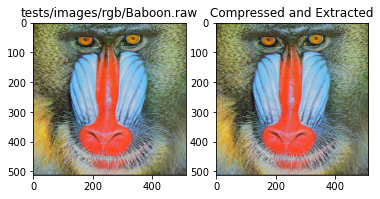

Original file size:  786432  Bytes
Time elapsed:  0.7821890329999999 seconds
Compressed file size:  23633  Bytes
Time elapsed:  1.0656953959999997  seconds
PSNR:  33.14707470470642


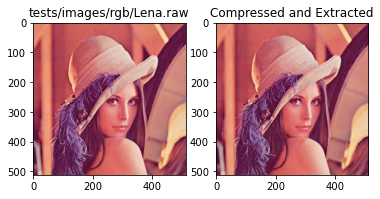

Original file size:  786432  Bytes
Time elapsed:  0.5893771400000007 seconds
Compressed file size:  9139  Bytes
Time elapsed:  0.7334115470000002  seconds
PSNR:  28.57595281845178


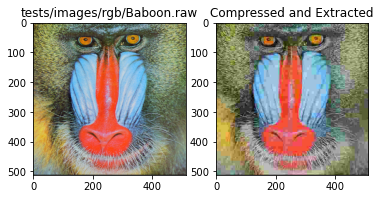

Original file size:  786432  Bytes
Time elapsed:  0.5715007749999996 seconds
Compressed file size:  6432  Bytes
Time elapsed:  0.6561639380000006  seconds
PSNR:  29.175528342059746


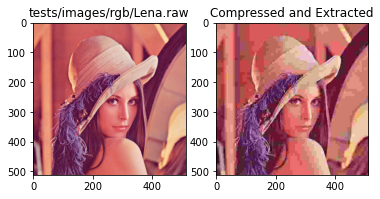

Original file size:  262144  Bytes
Time elapsed:  0.7573486819999999 seconds
Compressed file size:  45167  Bytes
Time elapsed:  1.461459585  seconds
PSNR:  31.043229143110285


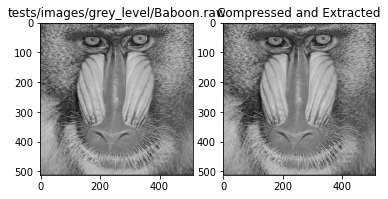

Original file size:  262144  Bytes
Time elapsed:  0.529407259000001 seconds
Compressed file size:  20478  Bytes
Time elapsed:  0.8366432400000008  seconds
PSNR:  36.1737351960732


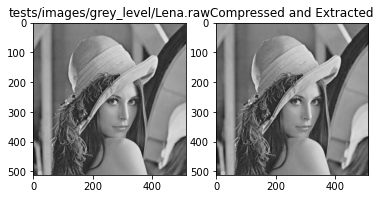

In [11]:
example()